In [1]:
! apt-get install git

!git clone https://github.com/RemiVaucher/Thesis

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'Thesis'...
remote: Enumerating objects: 457, done.
remote: Total 457 (delta 0), reused 0 (delta 0), pack-reused 457 (from 1)
Receiving objects: 100% (457/457), 282.23 MiB | 15.78 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (420/420), done.


In [ ]:
!pip install signatory
!pip install networkx
!pip install gudhi
!pip install sortedl1
!pip install mne
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.1 MB/s eta 0:00:00


In [ ]:
import json
import torch
import matplotlib.pyplot as plt
from os import listdir
#import drawing
import numpy as np
import librosa
from tqdm import tqdm
import time
import re
import gudhi
from gudhi.representations import BettiCurve

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

In [3]:
import sys
%cd Thesis/Chapter4/Acoustic

from algo import SigComplex
from TDA_utils import corr_metric, compute_complex, compute_pers_diag_manifold
from dataset import load_MultiTS
from dataset import preprocess, MA


[Errno 2] No such file or directory: 'Thesis/Chapter4/Acoustic'
/content/Thesis/Chapter4/Acoustic


ModuleNotFoundError: No module named 'signatory'

In [ ]:
### SigTDA parameters. [60,1,6e-5,3] works fine for MMII datas
params = {"win" : 60,
          "alpha_1d" : 1,
          "alpha_2d" : 6e-5,
          "depth" : 3
    }

In [ ]:
# Importing data

list_wav = []

list_label = []

expe = "MMII"

n_fft = 128

fft = True

if expe == "MMII":
    path = "./data/dev_"+expe+"/"+expe+"/"
    for individu in listdir(path+"normal"):
        df = librosa.load(path+'/normal/'+individu, sr = 44100)
        if fft:
            list_wav.append(librosa.stft(df[0],n_fft=n_fft))
        else:
            list_wav.append(librosa.feature.melspectrogram(y=df[0],n_fft=n_fft))
        list_label.append(0)
    for individu1 in listdir(path+"anormal"):
        df = librosa.load(path+'/anormal/'+individu1, sr = 44100)
        if fft:
            list_wav.append(librosa.stft(df[0],n_fft=n_fft))
        else:
            list_wav.append(librosa.feature.melspectrogram(df[0],n_fft=n_fft))
        list_label.append(1)

else:
    path = "./data/dev_"+expe+"/"+expe+"/test"

    for individu in listdir(path):
        df = librosa.load(path+'/'+individu, sr = 44100)
        if fft:
            list_wav.append(librosa.stft(df[0],n_fft=n_fft))
        else:
            list_wav.append(librosa.feature.melspectrogram(y=df[0],n_fft=n_fft,hop_length=32))
        if 'normal' in individu:
            list_label.append(0)
        else:
            list_label.append(1)




In [ ]:
comp = []

comp_by_col = []

betti = []

diag = []

persistence0 = []

persistence1 = []

persistence2 = []

betti_curve = []

100%|██████████| 100/100 [08:21<00:00,  5.01s/it]


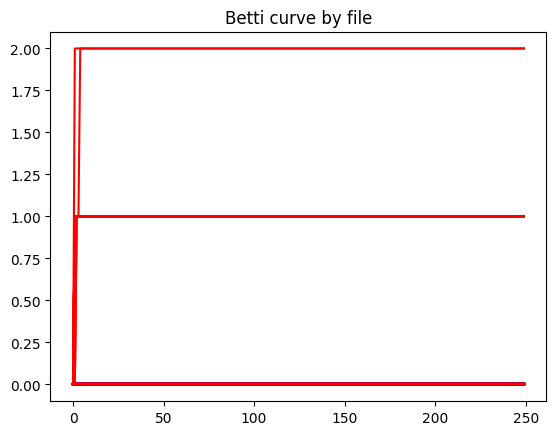

'\nfrom gudhi.wasserstein import wasserstein_distance\n\nB02 = np.zeros((l, l))\nB12 = np.zeros((l, l))\nB22 = np.zeros((l, l))\n\nfor i in range(l):\n    for j in range(i):\n        B02[i,j] = wasserstein_distance(persistence0[i], persistence0[j],matching = True)[0]\n        B12[i,j] = wasserstein_distance(persistence1[i], persistence1[j],matching = True)[0]\n        #B22[i,j] = wasserstein_distance(persistence2[i], persistence2[j],matching = True)[0]\n\n\nB02 = B02 + B02.transpose()\nB12 = B12 + B12.transpose()\nB12[B12==np.inf] = B12[B12!=np.inf].max()*10\nB22 = B22 + B22.transpose()\nB22[B22==np.inf] = B22[B22!=np.inf].max()*10\n\nfig1, axs1 = plt.subplots(2,6, figsize=(18,6))\n\nfor met in range(6):\n    compute_pers_diag_manifold([B02,B12],met = met ,n_comp = 2,col = col, distance = "Wasserstein",axs = axs1[:,met])\n\n'

In [ ]:
for i in tqdm(range(100)):

  MultiTS = MA(torch.tensor(list_wav[i]).T.float(),win_MA=30).float()[None]
  MultiTS -= MultiTS.mean(dim=-2)[:,None]

  '''
  On preprocess la TS comme d'hab'
  '''

  # initiate an instance of SigComplex
  com = SigComplex(MultiTS, win = MultiTS.shape[-2], depth = params["depth"], alpha_1d = params["alpha_1d"], alpha_2d = params["alpha_2d"],lasso=True, max_iter = 2000)

  _complex, _ = com.complex_creation(0,verbose=False)

  comp_by_col.append(_complex)

  _complex.set_dimension(3)
  # On doit calculer la persistance pour faire tout le reste
  _complex.compute_persistence()
  # On stocke les nombres de Betti de chaque couleur
  betti.append(_complex.betti_numbers())

  diag.append(_complex.persistence())


  persistence0.append(_complex.persistence_intervals_in_dimension(0))

  persistence1.append(_complex.persistence_intervals_in_dimension(1))

  persistence2.append(_complex.persistence_intervals_in_dimension(2))

  time.sleep(0.01)

#### On calcule la courbe de betti associée à chaque complexe (/!\ c'est différent des nombres de betti tout court)
bc = BettiCurve(sample_range=[0,2.5], resolution = 250)
bettis = bc.fit_transform(persistence2)

fig = plt.figure()
ax = fig.add_subplot(111)

col = []
for i in range(len(list_label)):
    if list_label[i]==0:
        col.append("blue")
    else:
        col.append("red")

for i in range(len(bettis)):
    ax.plot(bettis[i], color = col[i])

plt.title("Betti curve by file")
plt.show()

###### Distance entre diagramme de persistence #####

l = 100
col = col[:l]

'''
B01 = np.zeros((l, l))
B11 = np.zeros((l, l))
B21 = np.zeros((l, l))


for i in range(l):
    for j in range(i):
        B01[i,j] = gudhi.bottleneck_distance(persistence0[i], persistence0[j])
        #B11[i,j] = gudhi.bottleneck_distance(persistence1[i], persistence1[j])
        #B21[i,j] = gudhi.bottleneck_distance(persistence2[i], persistence2[j])


B01 = B01 + B01.transpose()
B11 = B11 + B11.transpose()
B11[B11==np.inf] = B11[B11!=np.inf].max()*10
B21 = B21 + B21.transpose()
B21[B21==np.inf] = B21[B21!=np.inf].max()*10

fig1, axs1 = plt.subplots(1,6,sharex = True, sharey=True,figsize= (6,1))
for met in range(6):
    compute_pers_diag_manifold([B01],met = met ,n_comp = 2,col = col, distance = "Bottleneck",axs = axs1[None,met])

'''
######### Même chose mais avec la distance de wasserstein


#fig1.suptitle('Embeddings of Wasserstein distance matrix')




/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_locally_linear.py:340: RuntimeWarning: divide by zero encountered in divide
  tmp[:, :nev] /= evals + reg[:, None]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_locally_linear.py:350: RuntimeWarning: invalid value encountered in divide
  rho = evals[:, n_components:].sum(1) / evals[:, :n_components].sum(1)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_locally_linear.py:358: RuntimeWarning: invalid value encountered in divide
  eta_range = evals_cumsum[:, -1:] / evals_cumsum[:, :-1] - 1
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_locally_linear.py:371: RuntimeWarning: invalid value encountered in scalar divide
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


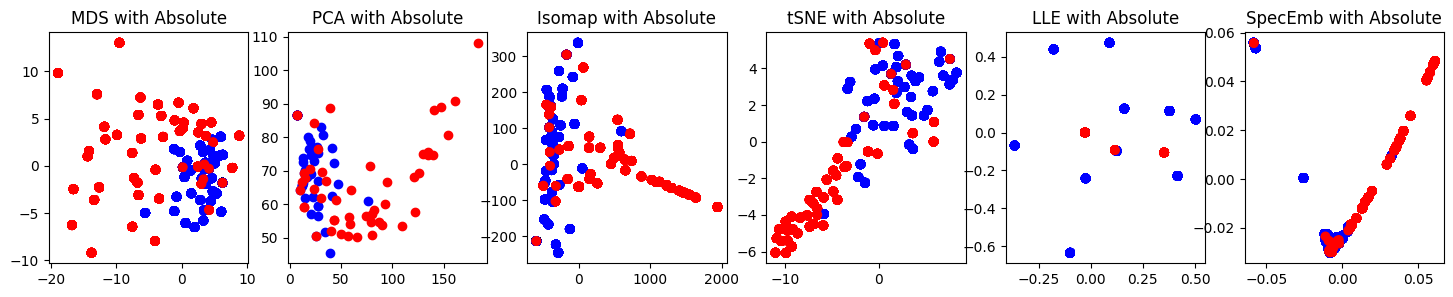

In [ ]:

from utils import simp_comp_abs_dist,simp_comp_adj


B0 = np.zeros((l,l))



for i in range(l):
    for j in range(i):
        B0[i,j] = simp_comp_abs_dist(comp_by_col[i], comp_by_col[j],MultiTS.shape[-1],2)

B0 = B0 + B0.transpose()
fig1, axs1 = plt.subplots(1,6,figsize= (18,3))

for met in range(6):
    compute_pers_diag_manifold([B0],met = met ,n_comp = 2,col = col, distance = "Absolute",axs = axs1[None,met])


/usr/local/lib/python3.10/dist-packages/gudhi/wasserstein/wasserstein.py:207: UserWarning: Cardinality of essential parts differs. Distance (cost) is +inf, and the returned matching is None.
  warnings.warn(f'{user_warning} Distance (cost) is +inf, and the returned matching is None.')
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:373: RuntimeWarning: invalid value encountered in divide
  b = b * a.sum() / b.sum()
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:388: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the

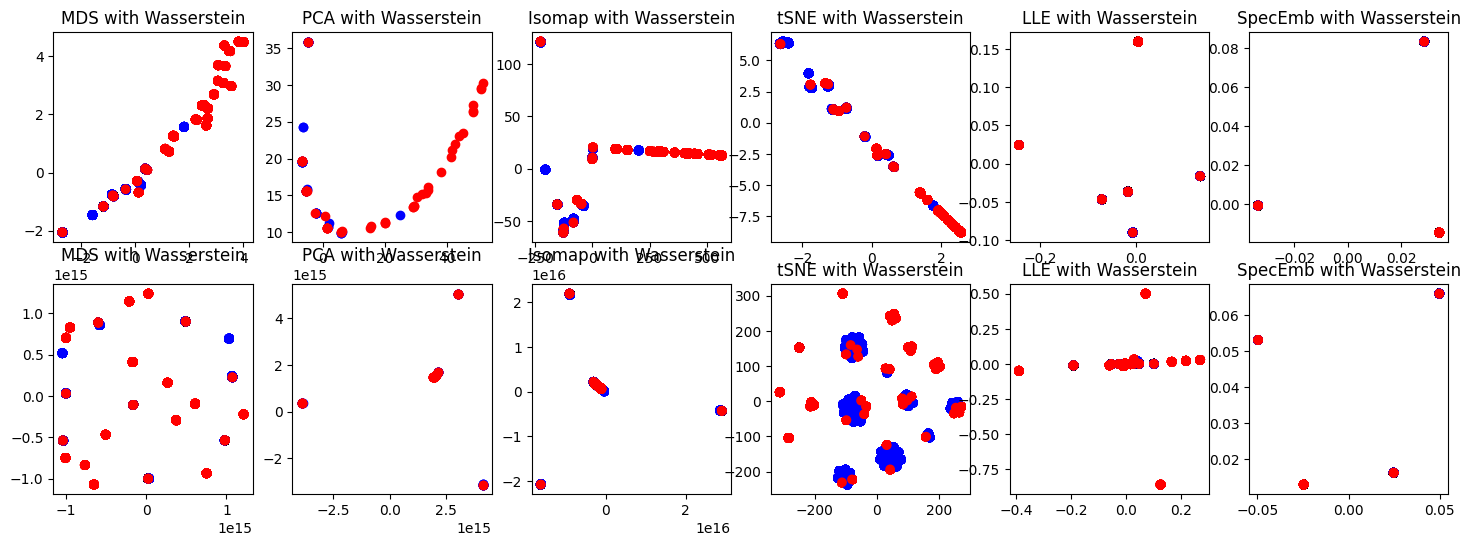

In [ ]:
from gudhi.wasserstein import wasserstein_distance

B02 = np.zeros((l, l))
B12 = np.zeros((l, l))
B22 = np.zeros((l, l))

for i in range(l):
    for j in range(i):
        B02[i,j] = wasserstein_distance(persistence0[i], persistence0[j],matching = True)[0]
        B12[i,j] = wasserstein_distance(persistence1[i], persistence1[j],matching = True)[0]
        #B22[i,j] = wasserstein_distance(persistence2[i], persistence2[j],matching = True)[0]


B02 = B02 + B02.transpose()
B12 = B12 + B12.transpose()
B12[B12==np.inf] = B12[B12!=np.inf].max()*10
B22 = B22 + B22.transpose()
B22[B22==np.inf] = B22[B22!=np.inf].max()*10

fig1, axs1 = plt.subplots(2,6, figsize=(18,6))

for met in range(6):
    compute_pers_diag_manifold([B02,B12],met = met ,n_comp = 2,col = col, distance = "Wasserstein",axs = axs1[:,met])
